# Visualize CNN Weights and Activations

In [1]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import skimage.filters
import keras
from keras.applications import vgg16
from keras import backend as K

# Allow graph embeding in notebook
%matplotlib inline

Using TensorFlow backend.


## Helper Functions

In [2]:
def tensor_summary(tensor):
    """Display shape, min, and max values of a tensor."""
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))

    
def normalize(image):
    """Takes a tensor of 3 dimensions (height, width, colors) and normalizes it's values
    to be between 0 and 1 so it's suitable for displaying as an image."""
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)


def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
    """
    images: A list of images. I can be either:
        - A list of Numpy arrays. Each array represents an image.
        - A list of lists of Numpy arrays. In this case, the images in
          the inner lists are concatentated to make one image.
    """
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11, 11 * height_ratio))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Is image a list? If so, merge them into one image.
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1


## Build VGG16 Convolutional Network

In [3]:
# Build a VGG16 Convolutional Network pre-trained on ImageNet
model = vgg16.VGG16(weights='imagenet')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

## Test the Model on Random Images

shape: (224, 224, 3)  min: 0  max: 255


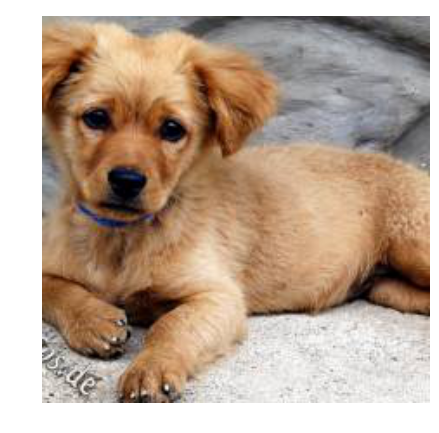

In [4]:
# Pick a random image from the Web.
# Make sure it's 224x224 image since VGG16 expects this size.
image = skimage.io.imread("http://lorempixel.com/224/224/animals/")
tensor_summary(image)
display_images([image], cols=2)

In [5]:
# Convert image to float
x = image.astype(np.float32)
# Make it a batch of one. The model expects a batch, not a single image
x = x[np.newaxis,...]
# Preprocess image. Convert RGB to BGR and subtract the ImageNet mean.
x = vgg16.preprocess_input(x)

In [6]:
# Classify the image
predictions = model.predict(x)
# We'll get a 1000 values. Print the first 10.
print(predictions[0][:10])

[  9.31408408e-08   9.02697650e-08   9.56123447e-09   8.43647285e-09
   4.50002062e-08   1.70791429e-06   6.90113723e-07   2.32295156e-06
   1.87407750e-05   1.91089995e-07]


In [7]:
# Find the largest confidence value. This corresponds to the label index.
label_index = np.argmax(predictions)
print("label index: ", label_index)
# Display the top 5 classes
vgg16.decode_predictions(predictions)

label index:  207


[[('n02099601', 'golden_retriever', 0.77799058),
  ('n02099712', 'Labrador_retriever', 0.030765017),
  ('n04409515', 'tennis_ball', 0.024390478),
  ('n02100877', 'Irish_setter', 0.022262534),
  ('n02094114', 'Norfolk_terrier', 0.019326003)]]

In [8]:
# List of ImageNet classes. Print a subset of the 1000
# The previous call to decode_predictions() sets the value
# of CLASS_INDEX, so call that function first.
imagenet_classes = keras.applications.imagenet_utils.CLASS_INDEX
for i in range(10):
    print(i, imagenet_classes[str(i)][1])

0 tench
1 goldfish
2 great_white_shark
3 tiger_shark
4 hammerhead
5 electric_ray
6 stingray
7 cock
8 hen
9 ostrich


## Heatmap

In [9]:
step = 56
heatmap_x = []
for row in range(0, image.shape[0], step):
    for col in range(0, image.shape[1], step):
        new_image = image.copy()
        # Add a square patch. Using a bright color here to make it easier to see.
        new_image[row:row+step, col:col+step, :] = [250,128,128]
        heatmap_x.append(new_image)
heatmap_x = np.stack(heatmap_x)
heatmap_x.shape

(16, 224, 224, 3)

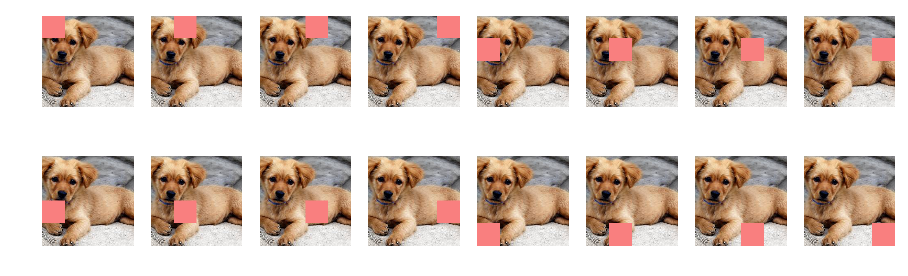

In [10]:
display_images(heatmap_x[:28], cols=8)

In [11]:
heatmap_y = model.predict(vgg16.preprocess_input(heatmap_x.astype(np.float32)))
tensor_summary(heatmap_y)

shape: (16, 1000)  min: 1.4533905190461383e-09  max: 0.8071998953819275


In [12]:
probs = heatmap_y[:, label_index]
tensor_summary(probs)

shape: (16,)  min: 0.5119819641113281  max: 0.8071998953819275


In [13]:
heatmap = (probs.max() - probs) / (probs.max()-probs.min())
heatmap = np.reshape(heatmap, (4, 4))
tensor_summary(heatmap)

shape: (4, 4)  min: 0.0  max: 1.0


shape: (4, 4)  min: 0.0  max: 1.0


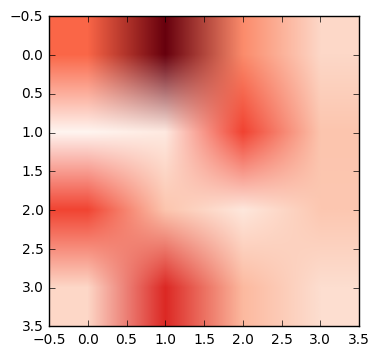

In [14]:
tensor_summary(heatmap)
_ = plt.imshow(heatmap, cmap=plt.cm.Reds)

shape: (224, 224, 3)  min: 0.0  max: 235.09718429381985


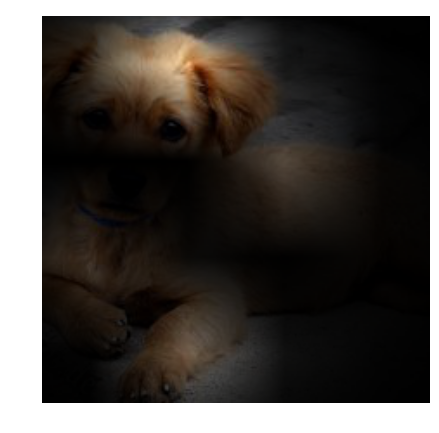

In [15]:
def apply_mask(image, mask):
    # Resize mask to match image size
    mask = skimage.transform.resize(normalize(mask), image.shape[:2])[:,:,np.newaxis].copy()
    # Apply mask to image
    image_heatmap = image * mask
    tensor_summary(image_heatmap)
    display_images([image_heatmap], cols=2)


# Apply mask to image
apply_mask(image, heatmap**2)

## Visualize the Weights

In [16]:
weights = model.get_layer("block1_conv1").get_weights()[0]
weights.shape, weights.min(), weights.max()

((3, 3, 3, 64), -0.67140007, 0.60851592)

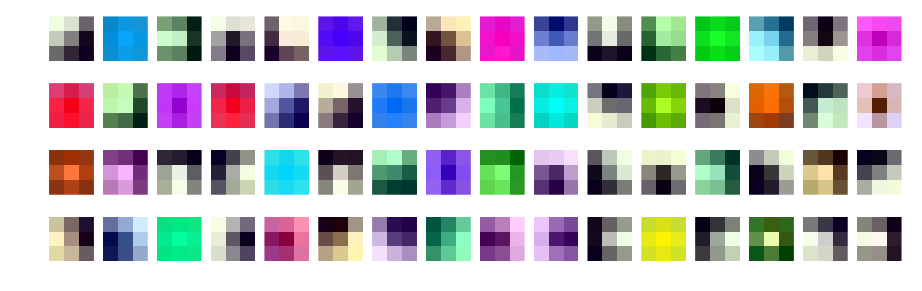

In [17]:
display_images([weights[:,:,::-1,i] for i in range(64)], cols=16, interpolation="none")

## Visualize Activations

In [18]:
def read_layer(model, x, layer_name):
    """Return the activation values for the specifid layer"""
    # Create Keras function to read the output of a specific layer
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    tensor_summary(outputs)
    return outputs[0]
    
def view_layer(model, x, layer_name, cols=5):
    outputs = read_layer(model, x, layer_name)
    display_images([outputs[:,:,i] for i in range(10)], cols=cols)

shape: (1, 224, 224, 64)  min: 0.0  max: 670.2743530273438


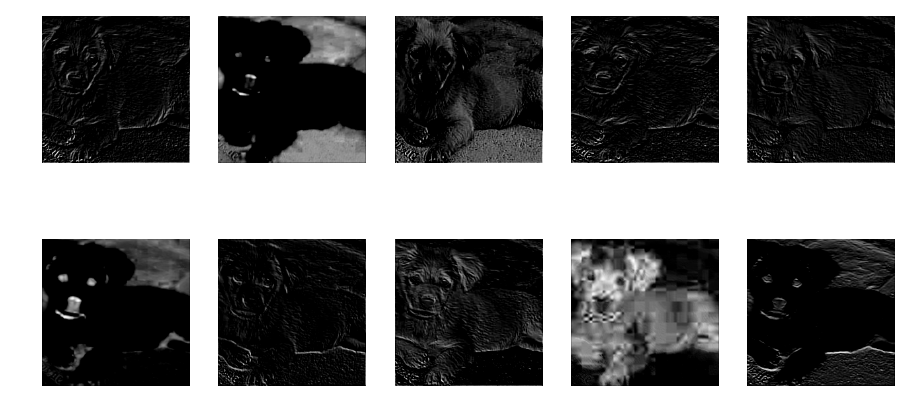

In [19]:
view_layer(model, x, "block1_conv1")

shape: (1, 224, 224, 64)  min: 0.0  max: 2532.182373046875


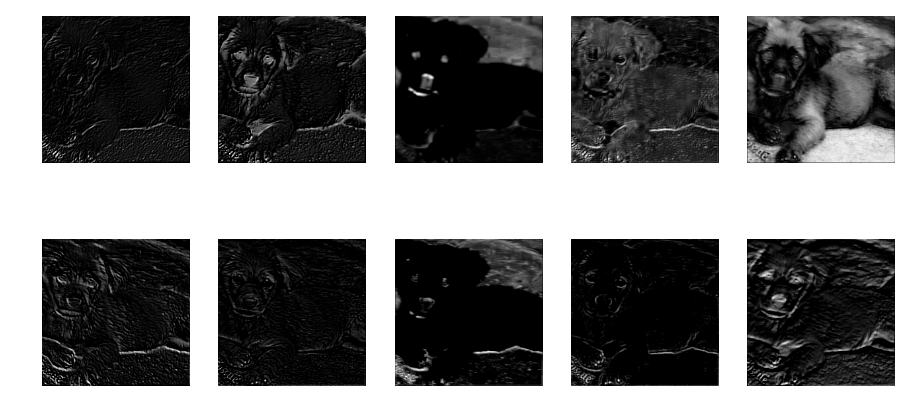

In [20]:
view_layer(model, x, "block1_conv2")

shape: (1, 112, 112, 128)  min: 0.0  max: 4760.607421875


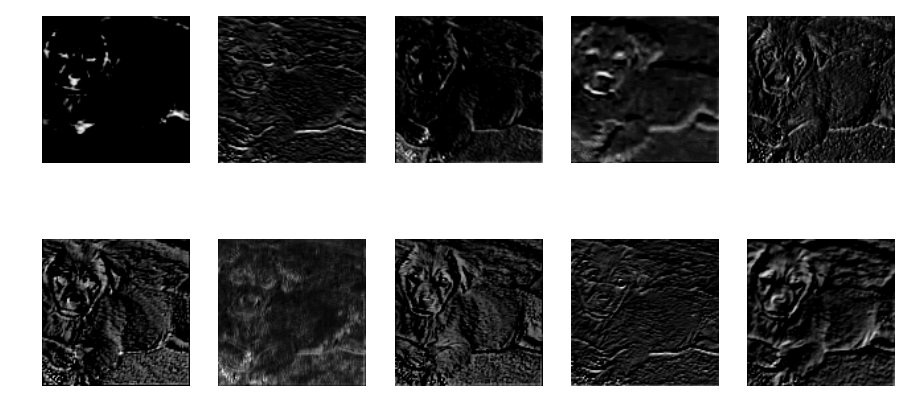

In [21]:
view_layer(model, x, "block2_conv1")

shape: (1, 56, 56, 256)  min: 0.0  max: 7696.4228515625


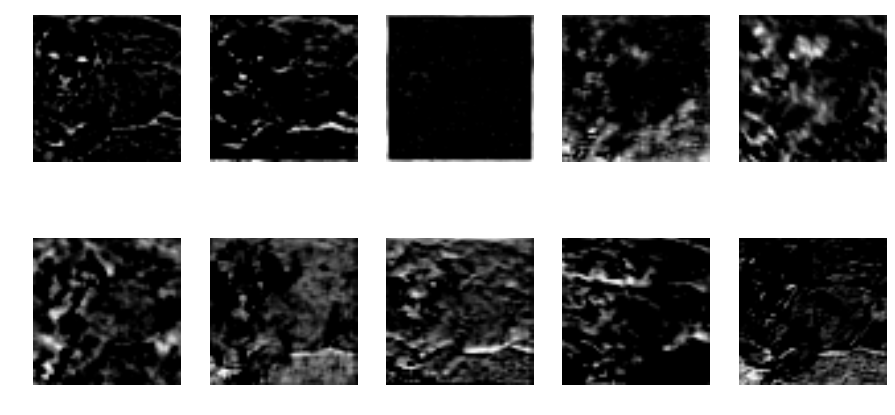

In [22]:
view_layer(model, x, "block3_conv1")

shape: (1, 28, 28, 512)  min: 0.0  max: 8226.205078125


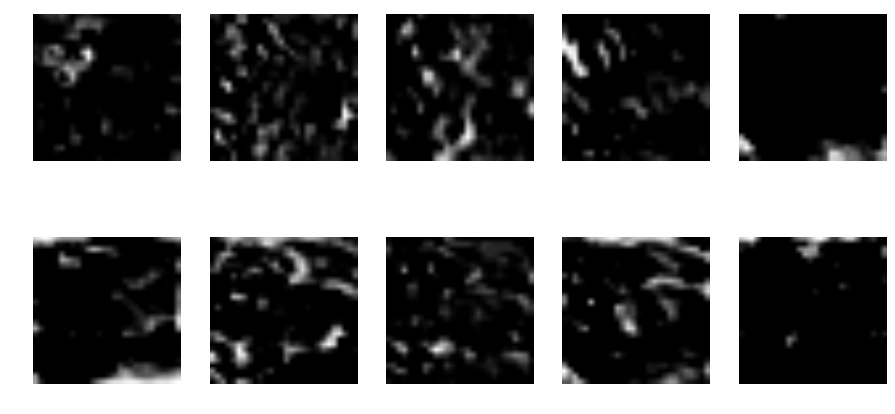

In [23]:
view_layer(model, x, "block4_conv1")

shape: (1, 14, 14, 512)  min: 0.0  max: 569.0444946289062


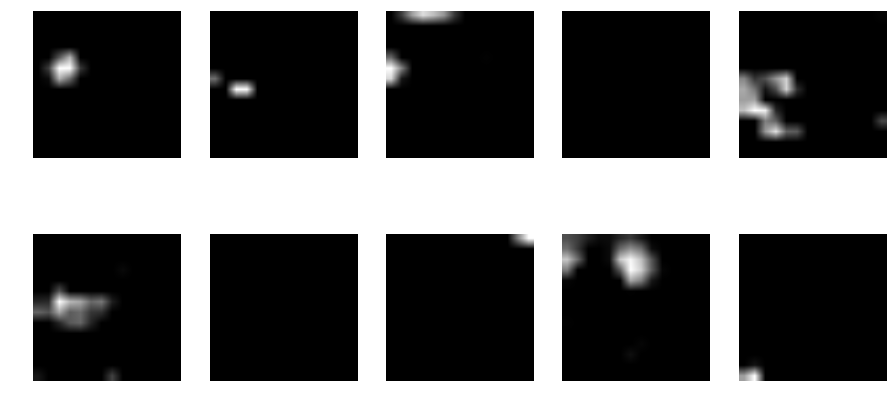

In [24]:
view_layer(model, x, "block5_conv3")

shape: (1, 14, 14, 512)  min: 0.0  max: 569.0444946289062
shape: (224, 224, 3)  min: 0.0  max: 176.3057617967715


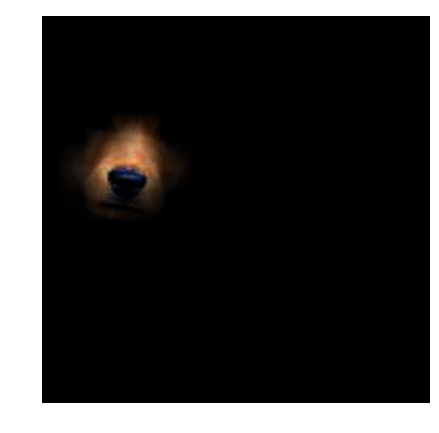

In [25]:
a = read_layer(model, x, "block5_conv3")
apply_mask(image, a[:,:,0])

shape: (1, 1000)  min: 4.081370796882311e-09  max: 0.7779905796051025


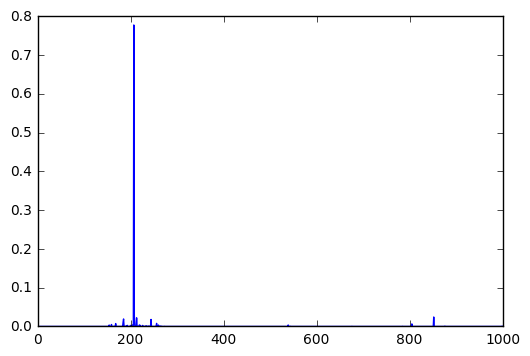

In [26]:
# The last layer is a 1D 1000-vector. Visualize as a bar chart.
a = read_layer(model, x, "predictions")
_ = plt.plot(a)

## Gradient Descent to Image Space

Or, gradient ascent, depending on which loss function you choose.

In [27]:
def build_backprop(model, loss):
    # Gradient of the input image with respect to the loss function
    gradients = K.gradients(loss, model.input)[0]
    # Normalize the gradients
    gradients /= (K.sqrt(K.mean(K.square(gradients))) + 1e-5)
    # Keras function to calculate the gradients and loss
    return K.function([model.input], [loss, gradients])

### Visualize the Gradients on the Input Image

shape: (1, 224, 224, 3)  min: -4.02213716506958  max: 4.483819007873535


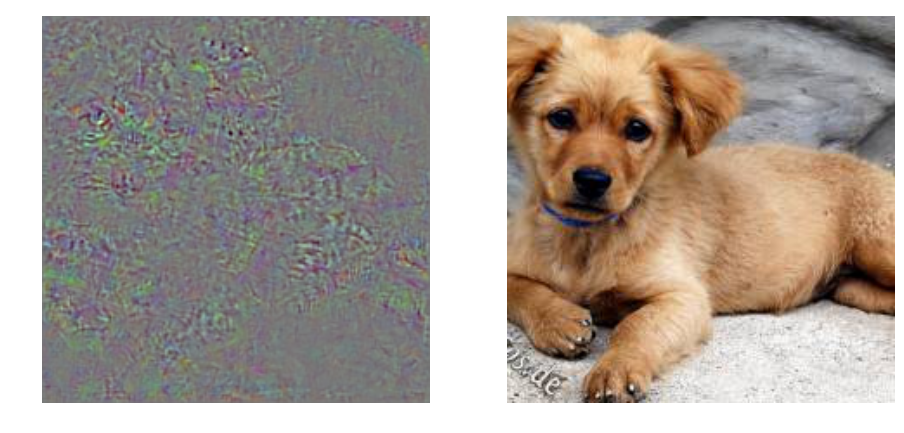

In [28]:
# Loss function that optimizes one class
loss_function = K.mean(model.get_layer("predictions").output[:,label_index])

# Backprop function
backprop = build_backprop(model, loss_function)

# Calculate gradients on the input image
loss, grads = backprop([x])
tensor_summary(grads)

# Visualize the gradients
grad_image = normalize(grads)
display_images([grad_image[0], image], cols=2)

## Generate an Image That Maximizes A Class 

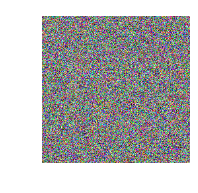

In [29]:
# Start with a random image
random_image = np.random.random((1, 224, 224, 3))
display_images(random_image)

Loss: 0.000423619
Loss: 0.179815
Loss: 0.895653
Loss: 0.964124
Loss: 0.98747
shape: (1, 224, 224, 3)  min: -14.690225545453854  max: 8.89817569212596


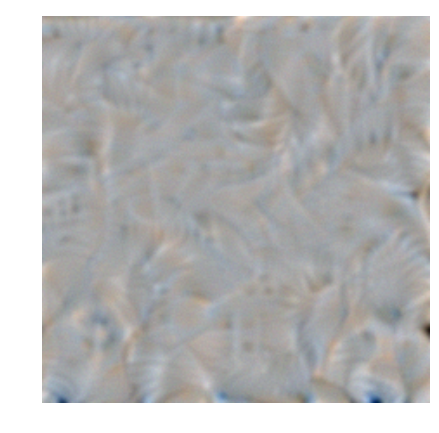

In [30]:
# Iteratively apply gradient ascent
for i in range(50):
    loss, grads = backprop([random_image])
    
    # Multiply gradients by the learning rate and add to the image
    # Optionally, apply a gaussian filter to the gradients to smooth
    # out the generated image. This gives better results.
    # The first line, which is commented out, is the native method
    # and the following line uses the filter. Try with both to
    # see the difference.
    #
    # random_image += grads * .1
    random_image += skimage.filters.gaussian(np.clip(grads, -1, 1), 2) 

    # Print loss value
    if i % 10 == 0:
        print('Loss:', loss)

tensor_summary(random_image)
display_images(random_image[...,::-1], cols=2)

In [31]:
# Classify the image
predictions = model.predict(random_image)
vgg16.decode_predictions(predictions)

[[('n02099601', 'golden_retriever', 0.99182159),
  ('n02099712', 'Labrador_retriever', 0.0022324915),
  ('n02102318', 'cocker_spaniel', 0.0009692263),
  ('n02104029', 'kuvasz', 0.00054418051),
  ('n02111500', 'Great_Pyrenees', 0.00047273043)]]

## Maximize Activations for a Hidden Filter

In [32]:
# Loss function that optimizes one class
loss_function = K.mean(model.get_layer("block1_conv1").output[:,:,:,0])

# Backprop function
backprop = build_backprop(model, loss_function)

# Start with a random image
random_image = np.random.random((1, 224, 224, 3)) 

Loss: 0.756642
Loss: 2.47781
Loss: 5.56178
Loss: 8.80982
Loss: 12.1198
shape: (1, 224, 224, 3)  min: -29.299892930529147  max: 30.71212066243689


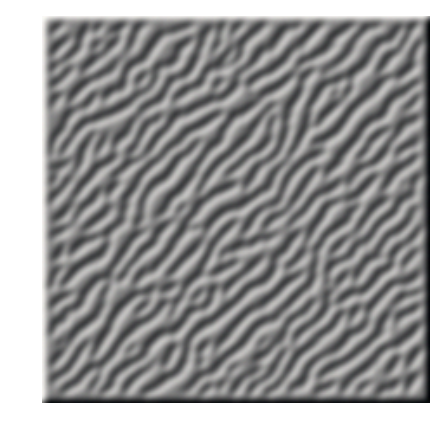

In [33]:
# Iteratively apply gradient ascent
for i in range(50):
    loss, grads = backprop([random_image])
    grads = np.nan_to_num(grads)  # In case gradients are NaN
    # Apply gradients with or without a gaussian filter
    # random_image += grads * .1
    random_image += skimage.filters.gaussian(np.clip(grads, -1, 1), 2) 
    if i % 10 == 0:
        print('Loss:', loss)

tensor_summary(random_image)
display_images(random_image[...,::-1], cols=2)

## Match Activations of Original Image

In [34]:
# Read activiations all all layers
activations = []
for layer in model.layers[1:]:
    # Extract activations
    get_layer_output = K.function([model.input], [layer.output])
    activations.append( (layer.name, get_layer_output([x])[0]) )
    tensor_summary(activations[-1][1])

shape: (1, 224, 224, 64)  min: 0.0  max: 670.2743530273438
shape: (1, 224, 224, 64)  min: 0.0  max: 2532.182373046875
shape: (1, 112, 112, 64)  min: 0.0  max: 2532.182373046875
shape: (1, 112, 112, 128)  min: 0.0  max: 4760.607421875
shape: (1, 112, 112, 128)  min: 0.0  max: 6875.05224609375
shape: (1, 56, 56, 128)  min: 0.0  max: 6875.05224609375
shape: (1, 56, 56, 256)  min: 0.0  max: 7696.4228515625
shape: (1, 56, 56, 256)  min: 0.0  max: 8705.396484375
shape: (1, 56, 56, 256)  min: 0.0  max: 11183.2568359375
shape: (1, 28, 28, 256)  min: 0.0  max: 11183.2568359375
shape: (1, 28, 28, 512)  min: 0.0  max: 8226.205078125
shape: (1, 28, 28, 512)  min: 0.0  max: 6634.0048828125
shape: (1, 28, 28, 512)  min: 0.0  max: 4412.837890625
shape: (1, 14, 14, 512)  min: 0.0  max: 4412.837890625
shape: (1, 14, 14, 512)  min: 0.0  max: 2993.5810546875
shape: (1, 14, 14, 512)  min: 0.0  max: 1042.8162841796875
shape: (1, 14, 14, 512)  min: 0.0  max: 569.0444946289062
shape: (1, 7, 7, 512)  min: 0.0

In [35]:
# Build the loss function
loss_function = 0
for l, a in activations:
    print(l)
    loss_function += K.mean(K.sqrt((model.get_layer(l).output - a)**2))
loss_function = -loss_function

# Backprop function
backprop = build_backprop(model, loss_function)

# Start with a random image
random_image = np.random.random((1, 224, 224, 3)) * 10

block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
fc1
fc2
predictions


Loss: -2355.43
Loss: -2259.85
Loss: -2205.76
Loss: -2205.76
Loss: -2205.76
shape: (1, 224, 224, 3)  min: -9.062849221396974  max: 20.46208533452051


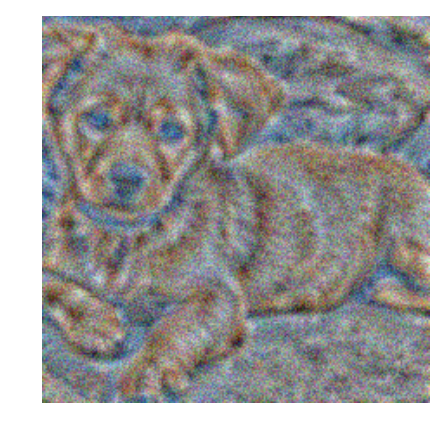

In [36]:
for i in range(50):
    loss, grads = backprop([random_image])
    grads = np.nan_to_num(grads)
    #random_image += grads * .1
    random_image += skimage.filters.gaussian(np.clip(grads, -1, 1), 2) 
    if i % 10 == 0:
        print('Loss:', loss)

tensor_summary(random_image)
display_images(random_image[...,::-1], cols=2)